In [1]:
!pip install fastai --upgrade -q

     |████████████████████████████████| 189 kB 2.9 MB/s 
     |████████████████████████████████| 56 kB 944 kB/s 


In [2]:
!pip install fastaudio

     |████████████████████████████████| 194 kB 7.1 MB/s 
     |████████████████████████████████| 183 kB 43.9 MB/s 
     |████████████████████████████████| 1.9 MB 27.9 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 804.1 MB 2.7 kB/s 
     |████████████████████████████████| 23.2 MB 1.5 MB/s 
     |████████████████████████████████| 23.3 MB 1.3 MB/s 
     |████████████████████████████████| 23.3 MB 44.5 MB/s 
     |████████████████████████████████| 22.1 MB 2.0 MB/s 
     |████████████████████████████████| 22.1 MB 1.4 MB/s 
     |████████████████████████████████| 17.4 MB 646 kB/s 
  Created wheel for librosa: filename=librosa-0.8.0-py3-none-any.whl size=201396 sha256=26a1857126aeb62e0dda67c59118e2fceba64396a08d9796b781320506aff871
  Stored in directory: /root/.cache/pip/wheels/de/1e/aa/d91797ae7e1ce11853ee100bee9d1781ae9d750e7458c95afb
  Created wheel for colorednoise: filename=colorednoise-1.1.1-py3-none-any.whl size=3983 sha256=bc8f8ed

# Clasificación de sonido
## Redes Neuronales 1 - Proyecto Final
### Juan Pablo Maldonado Castro - 420138620
### 10 de febrero de 2022

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm
import numpy as np
import pandas as pd

from IPython.lib.display import Audio

In [3]:
import fastaudio
import fastai.vision.all as fv
import fastaudio.core.all  as fa
from fastaudio.augment.all import *
from fastaudio.ci import skip_if_ci

/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:47: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  '"torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. '


# Objetivo

El objetivo de este proyecto es hacer clasificación de sonido con redes neuronales. Esto se va a hacer sobre el conjunto de datos *Speech Commands*, el cual contiene varias grabaciones de voz que pronuncian una sola palabra por clase.

#Cargando conjunto de datos

El conjunto de datos a utilizar es parte de la librería de *torch*. A partir de la siguiente sección de código de uno de sus tutoriales, podemos cargar todas las grabaciones correspondientes de audio que ocuparemos.

Referencia: https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html

In [5]:
from torchaudio.datasets import SPEECHCOMMANDS
import os

class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)
        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]

In [6]:
train_set = SubsetSC("training")

## Observando los datos

Ya tenemos el conjunto de datos. Estos tienen la siguiente información:
* Tensor de frecuencia en Hz de la señal de audio (tiene forma 1x sr)
* Sample rate (sr), representa el número de muestras que hay en una sola grabación.
* Clase, la palabra asociada a la grabación
* Id del hablador
* Clase con su valor numérico

In [56]:
ex = train_set[0]
ex

(tensor([[-0.0658, -0.0709, -0.0753,  ..., -0.0700, -0.0731, -0.0704]]),
 16000,
 'backward',
 '0165e0e8',
 0)

In [57]:
ex[0].shape

torch.Size([1, 16000])

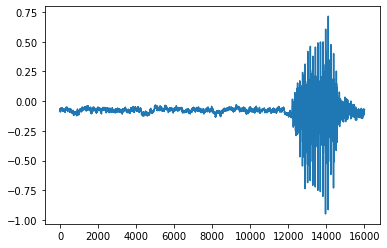

In [58]:
plt.plot(ex[0].t().numpy());

A continuación se muestra un ejemplo de muestra de audio con su etiqueta asociada:

In [59]:
example = train_set[2000]
print(f"Etiqueta: {example[2]}")
print("\nAudio asociado:")
Audio(example[0], rate = example[1])

Etiqueta: bed

Audio asociado:


Dentro del conjunto de datos, contamos con todas estas distintas palabras:

In [60]:
labels = sorted(list(set([train_set[i][2] for i in range(len(train_set))])))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

# Clasificando comandos de audio
## Método 1: transformación, de onda a espectrograma

Hay distintas formas de hacer clasificación de sonido, una de ellas se basa en convertir de longitud de onda a espectrograma. Cuando representemos el audio como espectrogramas, estaremos trabajando con la escala de Mel, en lugar de unidades de frecuencia en Hz. Esta escala está diseñada para representar el audio con base en la percepción del oído humano.

Para hacer esto, podemos usar librerías que nos permiten hacer transformaciones a la longitud de onda. Una de ellas es *fastaudio*. La transformación de señal a espectrograma con esta librería se describe en el siguiente [enlace](https://fastaudio.github.io/Introduction%20to%20Audio/#spectrogram-as-a-visual-representation-of-audio).

In [61]:
ex = train_set[0][0]
ex = fa.AudioTensor(ex)

cfg = fa.AudioConfig.BasicMelSpectrogram(n_fft = 512, #niveles de frecuencia que distingue/"corta".
                                         n_mels = 100, #"Altura" del espectrograma
                                         )
a2s = fa.AudioToSpec.from_cfg(cfg)

exSpec = a2s(ex)
exSpec

AudioSpectrogram([[[ 13.2765,  13.5480,  13.7806,  ...,  13.3213,  16.5310,  16.5892],
         [ 18.0044,  18.2760,  18.5086,  ...,  18.0492,  21.2590,  21.3172],
         [-10.9180,  -3.4328, -12.9832,  ..., -14.6552,  -5.2554,  -1.8539],
         ...,
         [-29.0498, -32.4173, -35.9059,  ..., -30.8704, -33.1514, -33.4364],
         [-32.2552, -36.5931, -34.2964,  ..., -35.1482, -34.8144, -31.6516],
         [-38.0655, -38.5924, -37.7509,  ..., -36.2234, -39.3622, -39.1339]]])

In [62]:
exSpec[0].shape
#exSpec[0,0:10,:] = 0
#exSpec

torch.Size([100, 63])

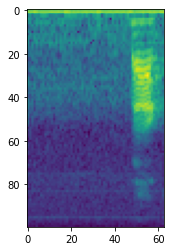

In [63]:
plt.imshow(exSpec[0])

## Cargando Datos

### Definiendo DataBlock y DataLoader

Con ayuda de *fastaudio* podemos definir nuestros datos de la misma forma que hacíamos con imágenes, solo cambiamos el tipo de bloques a *AudioBlock*.

Como transformaciones usaremos la que pasa de longitud de onda a espectrograma. Esto se hace en las siguientes funciones.

In [7]:
def load_data(folder, miliseconds = 1000 ,bs = 32, i_tfms = None, b_tfms = None):

  #DataBlock
  data = fv.DataBlock(blocks = (fa.AudioBlock(crop_signal_to=miliseconds), #Una transformación es crop, ajusta el tamaño del tensor de audio
                                fv.CategoryBlock),  
                                get_items = fa.get_audio_files,
                                splitter = fv.RandomSplitter(),
                                item_tfms = i_tfms,
                                batch_tfms = b_tfms,
                                get_y = fv.parent_label)
  
  return data.dataloaders(folder, bs = 32)

In [10]:
cfg = fa.AudioConfig.BasicMelSpectrogram(n_fft=512,
                                           n_mels = 100)
a2s = fa.AudioToSpec.from_cfg(cfg)

tfms = [a2s]

data = load_data("./", bs = 32, i_tfms = tfms)

A continuación vemos algunos de los espectrogramas generados a partir del audio junto a sus respectrivas etiquetas.

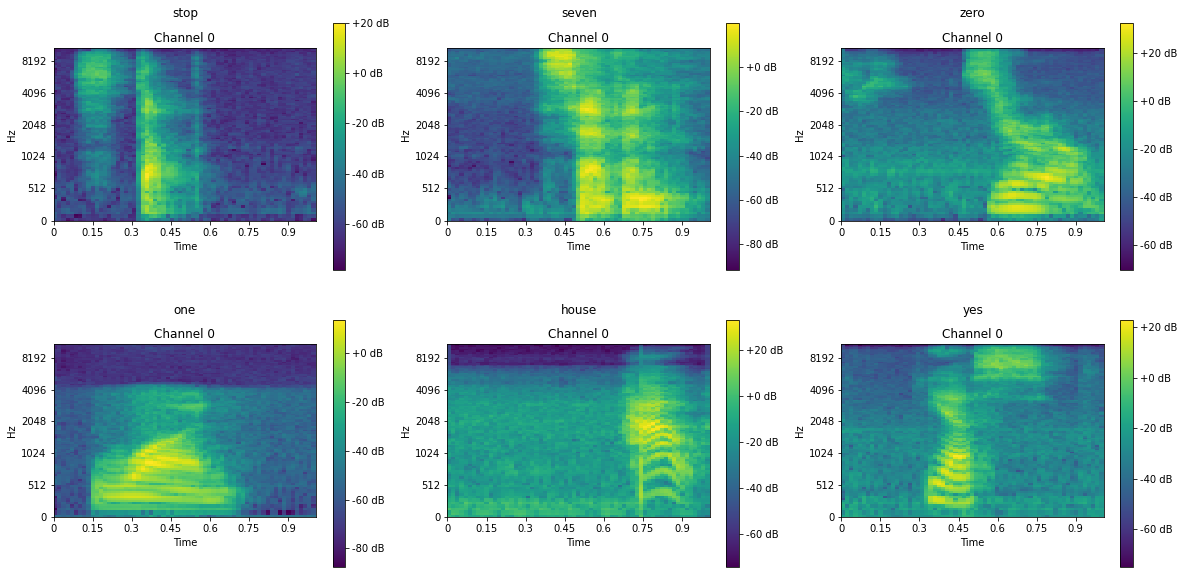

In [64]:
data.show_batch(figsize = (20,10), nrows = 2, ncols = 3)

## Entrenamiento con red neuronal preentrenada

En este caso, cuando creemos el learner y entrenemos, podemos tratar a los espectrogramas justo como imágenes. La única diferencia es que ya no tenemos tres canales RGB por imagen, solo trabajamos con uno.

Como primer ejemplo entrenemos el modelo preentrenado de *resnet18* para manejar esta clasificación.

In [65]:
learn = fv.cnn_learner(data,
                       fv.resnet18,
                       n_in = 1, #Un solo canal de entrada por espectrograma
                       metrics = fv.accuracy,
                       normalize = False)

In [66]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [67]:
learn.fit_one_cycle(3,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.227242,0.954182,0.716965,08:16
1,0.686262,0.554614,0.833609,08:15
2,0.597992,0.502552,0.848821,08:13


Una vez terminado el entrenamiento vemos cómo el modelo clasificó algunos de los espectrogramas.

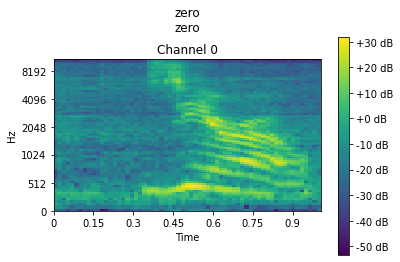

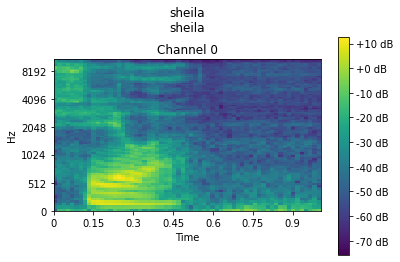

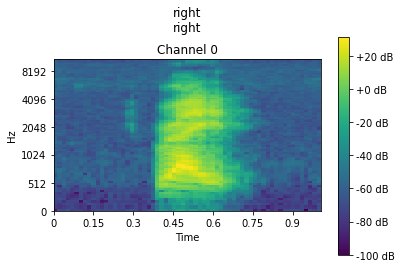

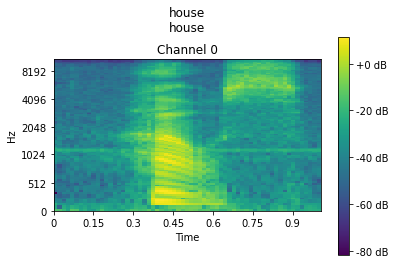

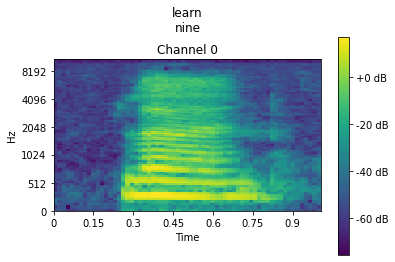

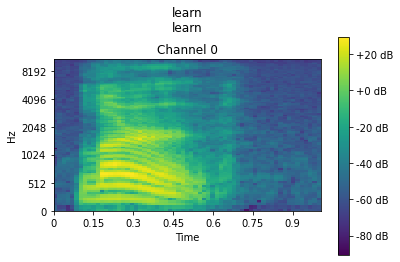

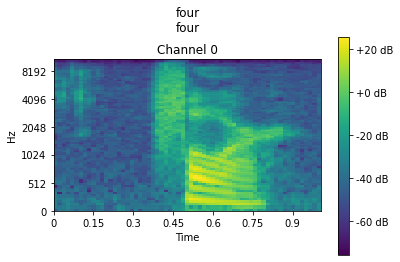

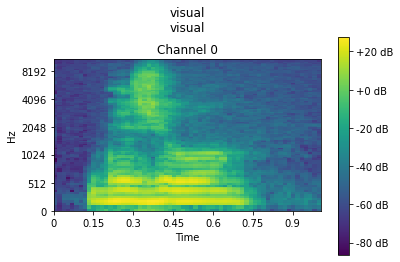

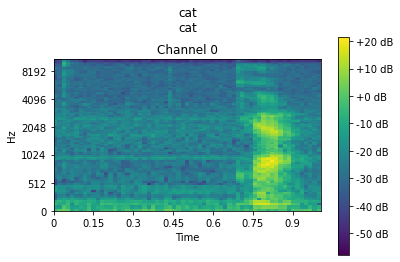

In [68]:
learn.show_results()

In [69]:
learn.save("resnetModel")

Path('models/resnetModel.pth')

In [74]:
learn.load("resnetModel")

In [75]:
#learn.cuda()

## Predicción de resultados individuales

Cuando estamos trabajando con audio, no es interesante ver cómo clasifica las imágenes generadas por los espectrogramas. Lo que nos interesa ver (o escuchar) es que la señal, es decir el audio, corresponda adecuadamente con la etiqueta.

Por esto mismo, a continuación hay unas funciones que, dado el modelo y el tensor de longitud de onda, en conjunto muestran un clip de audio junto con la predicción del modelo.

In [18]:
#Si el tensor no tiene el sample rate que usa el modelo, modificarlo
def fillCropTensor(waveform):
  sr = waveform.shape[1]
  if(sr < 16000):
    w2 = torch.cat([waveform[0], torch.zeros(16000 - sr)])
    return w2[None,:]
  if(sr > 16000):
    w2 = waveform[0][:16000]
    return w2[None,:]
  
  return waveform

#Devuelve la clase/etiqueta del sonido que se le pase
def predictSound(waveform, myLearner, spectrogram):
  #Transformaciones
  waveform = fillCropTensor(waveform)
  cfg = fa.AudioConfig.BasicMelSpectrogram(n_fft=512, n_mels = 100)
  a2s = fa.AudioToSpec.from_cfg(cfg)

  labels = myLearner.dls.vocab #etiquetas de clase
  tensor = waveform #arreglo de sonido
  at = AudioTensor(tensor) # Volverlo tensor de tipo 'audiotensor'

  if(spectrogram):
    at = a2s(at)[None,:,:,:] #Pasarlo a dimensión de batches [1,x,y,z]
  else:
    at = at[None,:,:]
  return labels[torch.argmax(myLearner.model(at.cuda()))]

# Muestra audio en el Notebook
def showAudio(waveform):
  display(Audio(waveform, rate = waveform.shape[-1]))

#Junta los resultados
def showPredictResult(waveform, myLearner, spectrogram = True):
  print(f"Predicción: {predictSound(waveform, myLearner, spectrogram)}")
  print("Audio:")
  showAudio(waveform);

In [78]:
showPredictResult(train_set[1600][0], learn, spectrogram = True)

Predicción: backward
Audio:


## Entrenamiento con red neuronal "manual"

Ya entrenamos con un modelo preentrenado de resnet18. Ahora experimentemos con un modelo "manual" de una red neuronal convolucional. Una vez más usamos el mismo tipo de capas y estructura que seguiríamos para clasificar imágenes. Recordemos que el único cambio viene en la entrada que recibe el modelo (1 en lugar de *3*). A continuación se encuentran las funciones que fueron de ayuda para definir el modelo. 

In [11]:
def num_params(model):
    total = 0
    for p in model.parameters():
        num = 1
        for s in list(p.size()):
            num *= s
        total += num
    return total

#Convolución -> Función de Activación -> BatchNorm
def convActBNorm(nIn, nOut, actFun = nn.ReLU(), extraLayers = None, **kwargs):
  layers = []
  layers += [nn.Conv2d(nIn, nOut, **kwargs)]
  layers += [actFun]
  layers += [nn.BatchNorm2d(nOut)]

  if(extraLayers != None):
    layers += extraLayers(nIn, nOut) #Debe ser función para añadir capas que ocupen nOut

  return layers

#Lineal -> Función de activación -> BatchNorm
def linAct(nIn, nOut, actFun = nn.ReLU(), extraLayers = None):
    layers = []
    layers += [nn.Linear(nIn,nOut)]
    layers += [actFun]
    layers += [nn.BatchNorm1d(nOut)]
    
    if(extraLayers != None):
        layers += extraLayers(nIn, nOut)
    return layers

#Capa flatten
class Flatten(nn.Module):
  def __init__(self):
    super().__init__()
    
  def forward(self, x):
    return x.reshape(x.shape[0],-1)

#Funciones de Resblock
class ResBlock(nn.Module):
    def __init__(self, residual):
        super().__init__()
        self.residual = residual
    def forward(self, x):
        return x+ self.residual(x)
    
def crear_residual(filters, actFun = nn.ReLU()):
    bottleneck = (filters +1)//2
    residual = nn.Sequential(
        nn.Conv2d(filters, bottleneck, kernel_size = 1),
        actFun,
        nn.BatchNorm2d(bottleneck),
        nn.Conv2d(bottleneck, bottleneck,  kernel_size = 3, padding = 1),
        actFun,
        nn.BatchNorm2d(bottleneck),
        nn.Conv2d(bottleneck, filters, kernel_size = 1),
        actFun,
        nn.BatchNorm2d(filters)
    )
    nn.init.constant_(residual[-1].weight,0)
    return residual

In [12]:
def create_model(firstLayers = None,
                 finalLayers = None,
                 prevLABLayers = None,
                 nIn = 3,
                 firstSize = 16,
                 iKSize =  6,
                 iPadding = 2,
                 KSize = 4,
                 padding = 1,
                 cbaBlocks = 5,
                 laBlocks = 1,
                 actFun = nn.ReLU(),
                 groups = "in_groups",
                 extraCBALayers = None,
                 extraLALayers = None):
  layers = []
    
  if(firstLayers != None):
      layers += firstLayers
    
  #Initial convolution
  layers += [nn.Conv2d(nIn, firstSize, kernel_size = iKSize, stride = 2, padding = iPadding)]
  layers += [nn.MaxPool2d(2)]
  layers += [nn.BatchNorm2d(firstSize)]
    
  #Series of Convolution -> Activation Function -> BatchNorm
  aux = firstSize
    
  for i in range(cbaBlocks):
    if(groups == "in_groups"):
      layers += convActBNorm(nIn = aux, nOut = aux*2, actFun = actFun, extraLayers = extraCBALayers,
                                   kernel_size = KSize, stride = 2, padding = padding, groups = aux)
    else:
      layers += convActBNorm(nIn = aux, nOut = aux*2, actFun = actFun, extraLayers = extraCBALayers,
                                   kernel_size = KSize, stride = 2, padding = padding, groups = groups)
    aux*=2
    
  #Linear part
  layers += [nn.AdaptiveAvgPool2d(1)]
  layers += [Flatten()]

  #Hacer split cuando comience la parte lineal
  splittingPoint = len(layers) - 1
  layers += [nn.BatchNorm1d(aux)]
    
  if(prevLABLayers != None):
    layers += prevLABLayers
    
  for i in range(laBlocks):
    layers += linAct(nIn = aux, nOut = aux//2, actFun = actFun, extraLayers = extraLALayers)
    aux //= 2
        
  if(finalLayers != None):
    layers += finalLayers
    
  layers += [nn.Linear(aux,data.c)]
    
  model = nn.Sequential(*layers)
    
  return model, splittingPoint

In [13]:
def create_learner(model, **kwargs):
  learn = fv.Learner(data, model, metrics = fv.accuracy, splitter = my_own_splitter)
  return learn

In [14]:
def extraLayers(nIn,nOut):
    return [ResBlock(crear_residual(nOut))]

model, splittingPoint = create_model(firstLayers = [nn.BatchNorm2d(1)],
                                     nIn = 1, cbaBlocks = 4, laBlocks = 2, groups = 1, extraCBALayers = extraLayers, iKSize= 7, iPadding = 3)

def my_own_splitter(m):
    return [list(group.parameters()) for group in[m[0:splittingPoint], m[splittingPoint:]]]

learnMan = create_learner(model)

In [105]:
learnMan.model

Sequential(
  (0): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ResBlock(
    (residual): Sequential(
      (0): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
      (7): ReLU()
      (

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=3.311311274956097e-06)

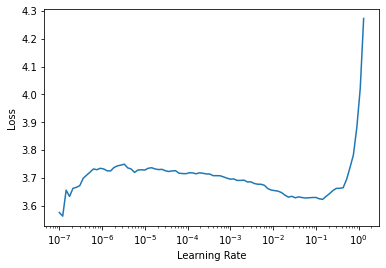

In [82]:
learnMan.lr_find()

Como se ve en la siguiente celda, ya generamos el modelo con varias capas que nos ayudarán a la clasificación de espectrogramas.

In [84]:
#learnMan.cuda()

In [ ]:
next(learnMan.model.parameters()).is_cuda 


True

In [106]:
learnMan.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.919486,0.798166,0.762271,08:25
1,0.507310,0.532385,0.839703,08:27
2,0.365747,0.343638,0.900033,08:16
3,0.258808,0.247046,0.924789,08:09
4,0.174578,0.231356,0.930600,08:07


Sorprendentemente tuvimos unos resultados muy buenos con este modelo manual. Con solo pasar las longitudes de onda a espectrogramas y tratarlas como imágenes pasamos a tener una *accuracy* de más del $90\%$ en cinco épocas.

Algo que probablemente contribuye mucho a la calidad de estos resultados es que el dataset con el que contamos es muy bueno. No hay mucho ruido de fondo en las grabaciones, son de tamaño similar, el volumen tampoco tiene muchos problemas, etc.

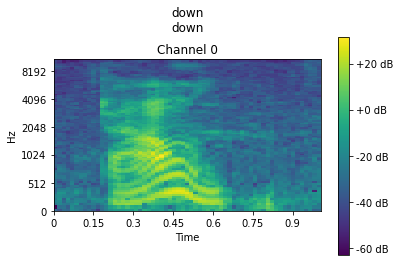

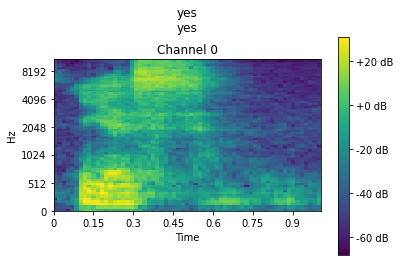

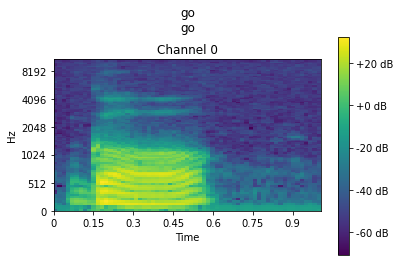

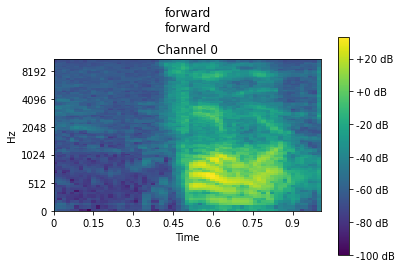

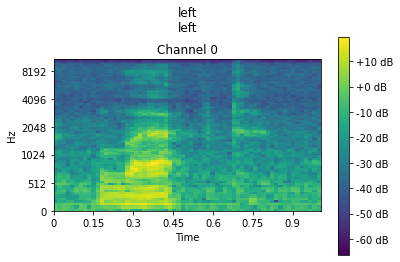

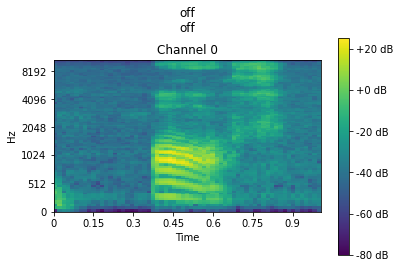

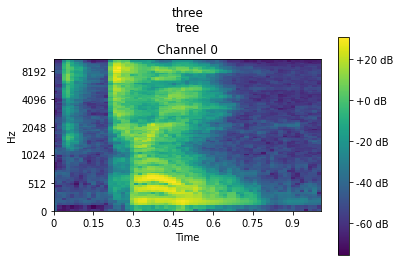

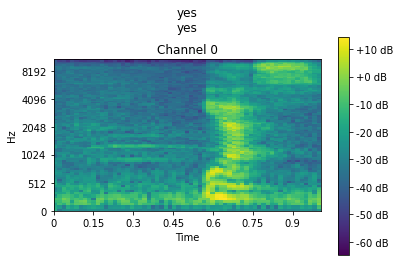

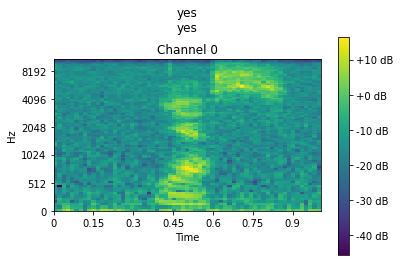

In [107]:
learnMan.show_results()

In [15]:
learnMan.save("ManModel")

Path('models/ManModel.pth')

In [27]:
#learnMan.load("ManModel")

In [21]:
#learnMan.cuda()

## Data Augmentation sobre espectrogramas

Sabemos que un sonido específico, genera un espectrograma específico. Como este espectrograma representa de manera muy precisa la onda de sonido correspondiente, nos vemos limitados ante el tipo de transformaciones que les podemos hacer. No tiene sentido aumentar o disminuir el brillo de la imagen o distorsionar la perspectiva de la misma.

Sin embargo, esto no significa que no haya transformaciones válidas que puedan ayudar a la clasificación de sonido por medio de espectrogramas. En esta sección veremos algunas de las [transformaciones a espectrogramas](https://fastaudio.github.io/API_Reference/augment.spectrogram/) que proporciona la librería de *fastaudio*.


Para comenzar, veamos cómo se vería un espectrograma normal.

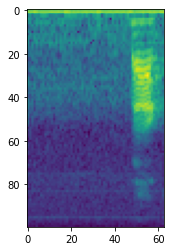

In [ ]:
ex = train_set[0][0]
ex = fa.AudioTensor(ex)
exSpec = a2s(ex)
plt.imshow(exSpec[0])

### Enmascaramiento de frecuencia

Lo primero que se puede hacer es cancelar o enmascarar un rango de frecuencia del sonido producido, esto se refleja en el eje $y$ del espectrograma.

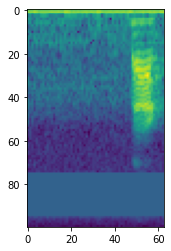

In [ ]:
ex = train_set[0][0]
ex = fa.AudioTensor(ex)
exSpec = a2s(ex)
plt.imshow(exSpec[0])

maskf = fastaudio.augment.spectrogram.MaskFreq()
plt.imshow(maskf(exSpec)[0])

### Enmascaramiento de tiempo

Otra transformación que podemos hacer es recortar algún segmento del audio para que esté completamente silenciado. Esto se hace con un enmascaramiento sobre el eje $x$ como se ve en el siguiente espectrograma.

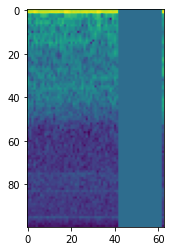

In [ ]:
ex = train_set[0][0]
ex = fa.AudioTensor(ex)
exSpec = a2s(ex)
plt.imshow(exSpec[0])

maskt = fastaudio.augment.spectrogram.MaskTime()

plt.imshow(maskt(exSpec)[0])

### Desplazamiento en el tiempo

Este tipo de enmascaramiento mueve en el eje de las $x$ la figura del espectrograma. Esto significa un cambio en el momento en que se reproduce un sonido (se reproduce a los 0.5 segundos, o a los 0.8, 0.1, etc.).

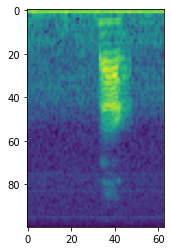

In [ ]:
ex = train_set[0][0]
ex = fa.AudioTensor(ex)
exSpec = a2s(ex)
plt.imshow(exSpec[0])

sgr = fastaudio.augment.spectrogram.SGRoll()

plt.imshow(sgr(exSpec)[0])

### Transformación con base en Delta

Este tipo de transformación implica crear un total de tres espectrogramas asociados al mismo sonido. Cuando se tiene un espectrograma "base", se pueden extraer distintas características de sonido a partir de ellos y se generan otros dos espectrogramas conocidos como Delta de orden 1 y 2.

En este caso, la librería crea esos dos espectrogramas delta y los concatena con el original, para tener distintas formas de representar el mismo sonido.

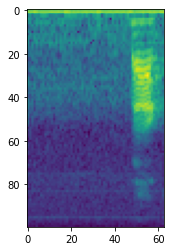

In [ ]:
ex = train_set[0][0]
ex = fa.AudioTensor(ex)
exSpec = a2s(ex)
plt.imshow(exSpec[0])

dta = fastaudio.augment.spectrogram.Delta()

plt.imshow(dta(exSpec)[0])

### Aplicando las transformaciones a un entrenamiento

Ahora apliquemos algunas de estas transformaciones para entrenar un modelo idéntico al manual que usamos en el punto anterior.

In [ ]:
cfg = fa.AudioConfig.BasicMelSpectrogram(n_fft=512,
                                           n_mels = 100)
a2s = fa.AudioToSpec.from_cfg(cfg)
maskf = fastaudio.augment.spectrogram.MaskFreq(size = 10)
maskt = fastaudio.augment.spectrogram.MaskTime(size = 10)
sgr = fastaudio.augment.spectrogram.SGRoll()
dta = fastaudio.augment.spectrogram.Delta()

tfms = [a2s,maskf,maskt,sgr]

data = load_data("./", bs = 32, i_tfms = tfms)

En el siguiente conjunto de espectrogramas se ilustran las distintas transformaciones que añadimos.

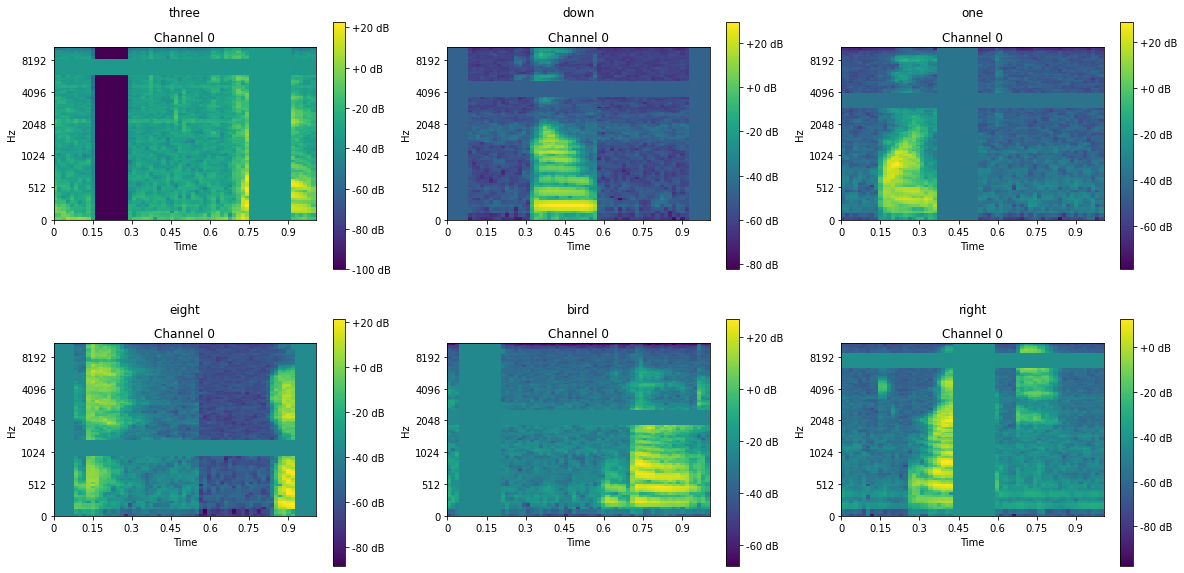

In [ ]:
data.show_batch(figsize = (20,10), nrows = 2, ncols = 3)

In [ ]:
def extraLayers(nIn,nOut):
    return [ResBlock(crear_residual(nOut))]

model, splittingPoint = create_model(cbaBlocks = 4, 
                                     laBlocks = 2,
                                     groups = 1,
                                     nIn = 1,
                                     extraCBALayers = extraLayers,
                                     iKSize= 7, iPadding = 3)

def my_own_splitter(m):
    return [list(group.parameters()) for group in[m[0:splittingPoint], m[splittingPoint:]]]

learnManAug = create_learner(model)

In [ ]:
learnManAug.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.515130,1.393959,0.593046,11:36
1,1.056249,1.010428,0.700808,11:31
2,0.880321,0.756718,0.773137,11:24
3,0.675355,0.616464,0.812775,11:22
4,0.644935,0.564408,0.829121,11:19


Como podemos observar, el modelo en este caso tuvo un peor desempeño con estas transformaciones que colocamos.

La causa principal de este problema probablemente se debe a que nuestros fragmentos de audio son de tiempo muy pequeño y los enmascaramientos cubren gran parte del audio de la palabra. Además como los audios son pequeños, y las palabras por sí solas cubren gran parte del eje $x$ del espectrograma, puede que los resultados de transformaciones como el desplazamiento en el tiempo afecten negativamente al análisis de las palabras por sí solas.

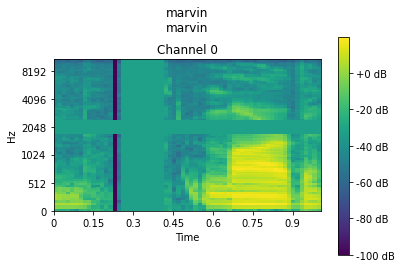

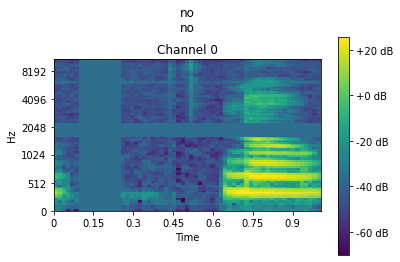

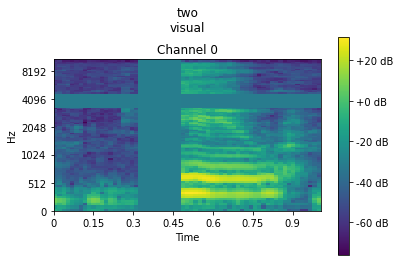

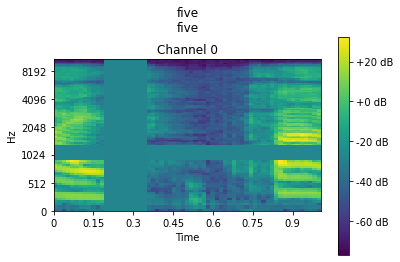

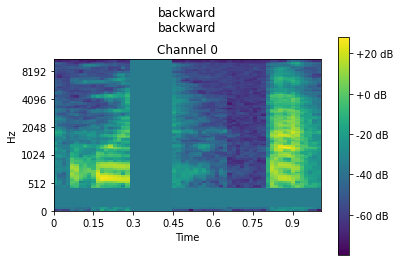

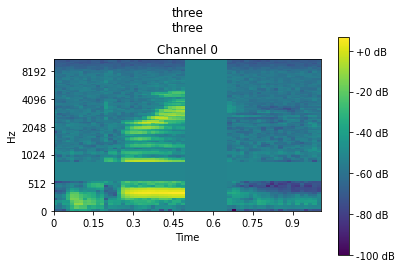

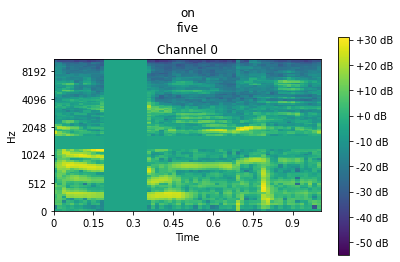

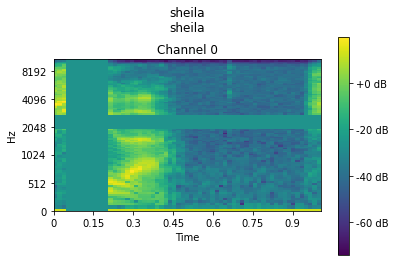

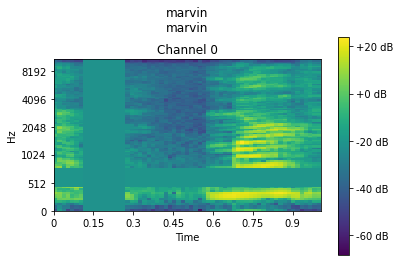

In [ ]:
learnManAug.show_results()

In [ ]:
showPredictResult(train_set[101012][0],learnManAug, spectrogram = True)

torch.Size([1, 16000])
Predicción: yes


## Método 2: entrenamiento sobre el tensor de frecuencia

Otro método que se utiliza para la clasificación de sonido es aplicar el entrenamiento directamente sobre el tensor de frecuencia. Esta vez no se hace una transformación a alguna imagen que represente el sonido (el espectrograma).

### Cargando los datos

Para cargar los datos volvemos a usar la misma librería de *fastaudio*, pero ahora simplemente no aplicamos ninguna transformación de señal de sonido a espectrograma a nuestros datos.



In [ ]:
data = load_data("./", bs = 32)

Como podremos observar en la siguiente celda, nuestros datos ahora están en otro formato. Ya no los vamos a poder tratar directamente como imágenes en esta ocasión. A pesar de ello el proceso que vamos a seguir sigue siendo muy similar.

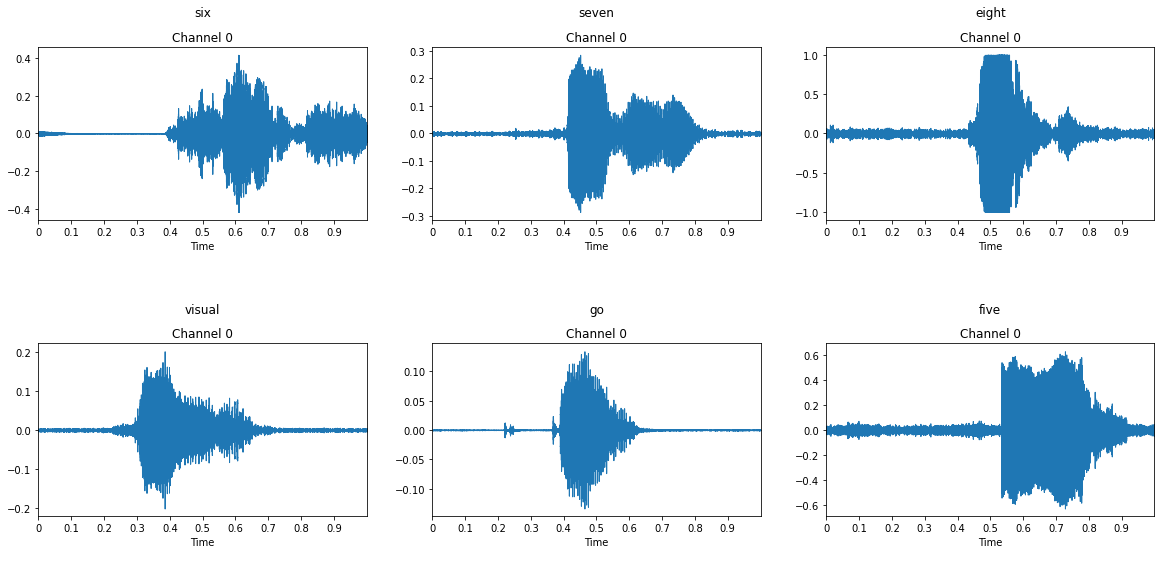

In [ ]:
data.show_batch(figsize=(20,10),nrows = 2, ncols = 3)

### Definiendo modelo y entrenando

Para entrenar este modelo, nos vamos a basar en la estructura general que tiene la red neuronal propuesta por [este tutorial](https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html) de *pytorch*. 

Consiste de una red convolucional con BatchNorm y convoluciones de una dimensión.

Algo importante, es que en nuestras capas de entrada, el tamaño del primer filtro (el kernel_size) debe ser algo grande. Se dice que la razón de esto es que cuando procesamos una señal de por ejemplo 8kHz, un kernel_size de 80 equivale a recibir alrededor 10 milisegundos de audio en conjunto. Si se baja más de eso, se dice que entonces el modelo ocuparía demasiadas capas para poder llegar a abstraer las características de un sonido a alto nivel.

En este caso estaríamos trabajando con 16kHz, por lo tanto usaremos un kernel_size de 160 para que en los primeros filtros de la red se reciban 10 milisegundos de audio. Se dice que este ventana de tiempo suele ser de las más comunes cuando se trabaja con clasificación de audio.

Para más referencias acerca de la arquitectura de esta red neuronal, también se puede consultar el siguiente [paper](https://arxiv.org/pdf/1610.00087.pdf). El cual es exactamente el mismo en el que se basaron los que hicieron el tutorial para clasificación de audio en *pytorch*.

En la siguiente celda definimos algunas funciones adicionales que ayudan a construir el modelo que ocupamos.

In [ ]:
#Conv -> Fun_act -> BatchNorm -> MaxPool (1d)
def ConvActNormMP1d(nIn, nOut, actFun = nn.ReLU(), **kwargs):
  layers = []
  layers += [nn.Conv1d(nIn,nOut, **kwargs)]
  layers += [nn.BatchNorm1d(nOut)]
  layers += [nn.MaxPool1d(4)]
  return layers

# residual para el resblock, ahora en 1d
def crear_residual(filters, actFun = nn.ReLU()):
    bottleneck = (filters +1)//2
    residual = nn.Sequential(
        nn.Conv1d(filters, bottleneck, kernel_size = 1),
        actFun,
        nn.BatchNorm1d(bottleneck),
        nn.Conv1d(bottleneck, bottleneck,  kernel_size = 3, padding = 1),
        actFun,
        nn.BatchNorm1d(bottleneck),
        nn.Conv1d(bottleneck, filters, kernel_size = 1),
        actFun,
        nn.BatchNorm1d(filters)
    )
    nn.init.constant_(residual[-1].weight,0)
    return residual


#Crear modelo
def createWavModel(iKsize = 160, iStride = 16):
  aux = 32
  layers = []
  layers += [nn.BatchNorm1d(1)]
  layers += ConvActNormMP1d(1,aux, kernel_size = iKsize, stride = iStride)

  for i in range(3):
    layers += ConvActNormMP1d(aux,aux*2, kernel_size = 3)
    layers += [ResBlock(crear_residual(aux*2))]
    aux = aux*2

  layers += [nn.AdaptiveAvgPool1d(1)]
  layers += [Flatten()]
  for i in range(2):
    layers += linAct(aux, aux//2)
    aux //= 2

  layers += [nn.Linear(aux, data.c)]
  #layers += [nn.LogSoftmax(dim = 2)]
  model = nn.Sequential(*layers)
  return model

Ya que contamos con esto, ahora sí definimos el modelo con las consideraciones que ya mencionamos anteriormente.

In [ ]:
model = createWavModel()
model

Sequential(
  (0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Conv1d(1, 32, kernel_size=(160,), stride=(16,))
  (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (7): ResBlock(
    (residual): Sequential(
      (0): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
      (1): ReLU()
      (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): ReLU()
      (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (7

In [ ]:
learnWav2 = fv.Learner(data, model, metrics = fv.accuracy)

Entrenando el modelo obtenemos los siguientes resultados.


SuggestedLRs(lr_min=0.003981071710586548, lr_steep=0.0014454397605732083)

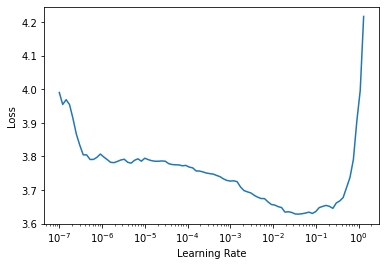

In [ ]:
learnWav2.lr_find()

In [ ]:
learnWav2.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.238827,1.194345,0.652856,05:28
1,0.749006,3.117065,0.778996,05:26
2,0.536857,7.976398,0.849246,05:24
3,0.364008,5.429315,0.894600,05:25
4,0.296280,3.239278,0.907356,05:22


Como podemos observar, esta técnica también trae muy buenos resultados. Ya no  fue necesario hacer una transformación hacia nuestros datos y pudimos alcanzar una *accuracy* de alrededor del $90\%$ en tan solo cinco épocas.


In [ ]:
learnWav2.save("learnWav")

Path('models/learnWav.pth')

In [ ]:
learnWav2.load("learnWav")

Aquí podemos probar algunos de los resultados:

In [ ]:
showPredictResult(train_set[85842][0], learnWav2, spectrogram = False)

Predicción: tree
Audio:


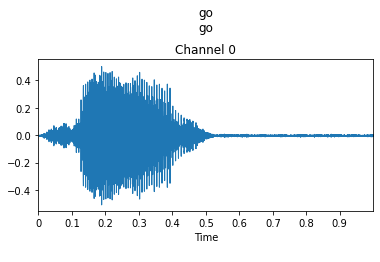

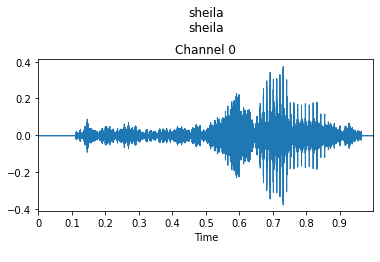

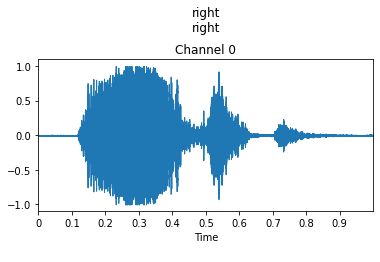

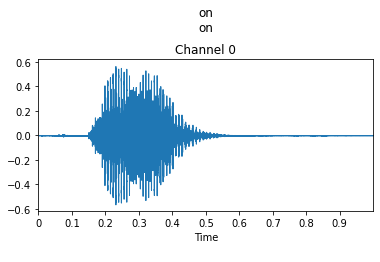

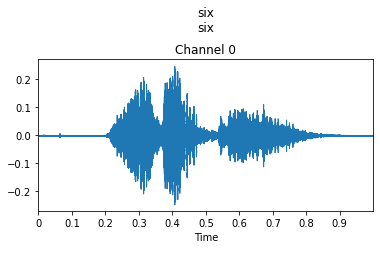

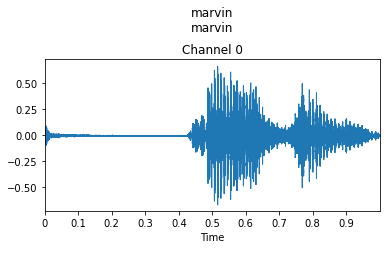

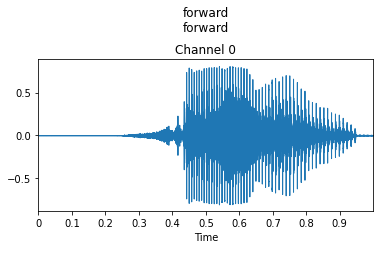

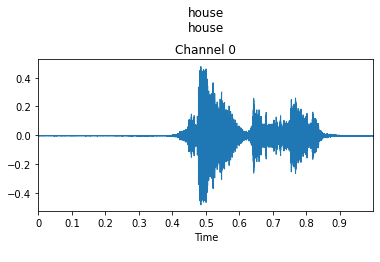

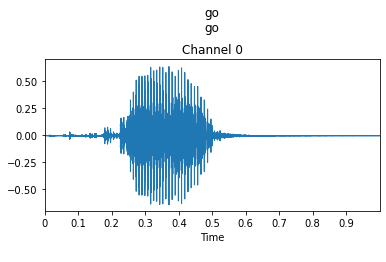

In [ ]:
learnWav2.show_results()

### Probando otro modelo

Como habíamos comentado en el modelo anterior, una recomendación que se hace al momento de tratar de entrenar sobre el tensor de frecuencia es que en las primeras capas tengamos un filtro (kernel_size) grande. Para comprobar qué tan cierto es esto, usemos exactamente el mismo modelo que en la sección anterior con la única modificación siendo el kernel_size, el cual reduciremos a 4.

In [ ]:
model = createWavModel(iKsize = 4, iStride = 3)
model

Sequential(
  (0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Conv1d(1, 32, kernel_size=(4,), stride=(3,))
  (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (7): ResBlock(
    (residual): Sequential(
      (0): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
      (1): ReLU()
      (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): ReLU()
      (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (7): 

In [ ]:
learnWav = fv.Learner(data, model, metrics = fv.accuracy)

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=7.585775847473997e-07)

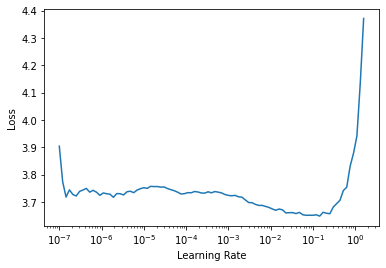

In [ ]:
learnWav.lr_find()

In [ ]:
learnWav.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.405423,1.454913,0.617990,04:53
1,1.023807,8.651355,0.298153,04:34
2,0.813737,2.980611,0.368498,04:26
3,0.615390,4.993534,0.538055,04:25
4,0.567188,1.837620,0.829782,04:29


Dados estos resultados, es evidente que lo que nos decía tanto el [tutorial de pytorch](https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html) como el [paper](https://arxiv.org/pdf/1610.00087.pdf) es cierto. Nuestra *accuracy*, empezó en un buen lugar para la primer época, pero luego bajó significativamente y se empezó a recuperar de poco en poco. Al final no logró alcanzar en sus cinco épocas al otro modelo que planteamos para tensores de onda.

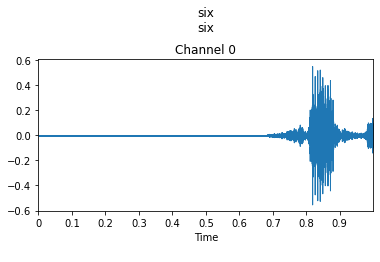

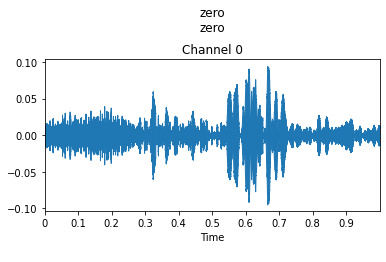

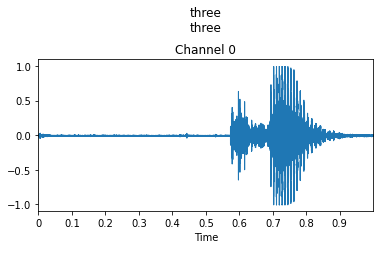

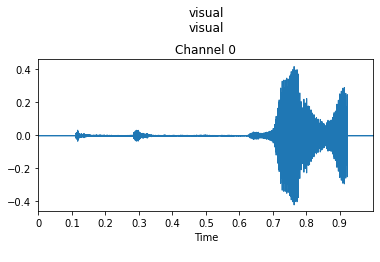

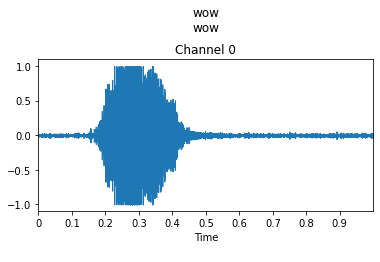

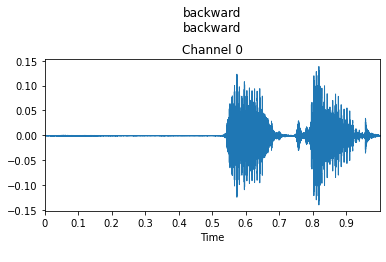

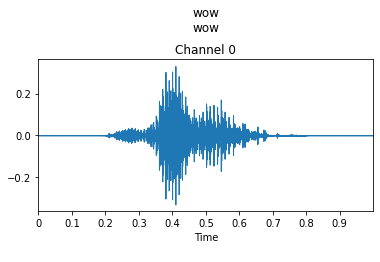

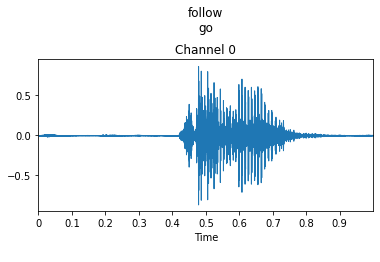

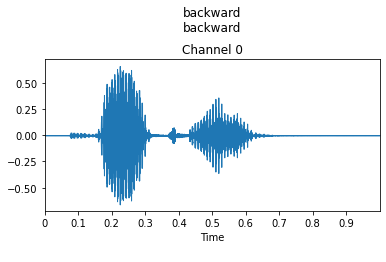

In [ ]:
learnWav.show_results()

In [ ]:
learnWav.save("learnWavBad")

Path('models/learnWavBad.pth')

In [ ]:
learnWav.load("learnWavBad")

## Data Augmentation para las ondas de sonido

Al igual que con los espectrogramas, también es posible aplicar ciertas transformaciones al sonido que tenemos durante el entrenamiento. Estas también pueden ser aplicadas por *fastaudio*. En el siguiente [enlace](https://fastaudio.github.io/API_Reference/augment.signal/) se encuentran todas las disponibles.

Un ejemplo de ellas es la de *ResizeSignal*, esta simplemente recorta el sonido para que dure un cierto periodo de tiempo (ya sea al inicio o al final del audio).

Como ejemplo, veamos el siguiente tensor de frecuencia:

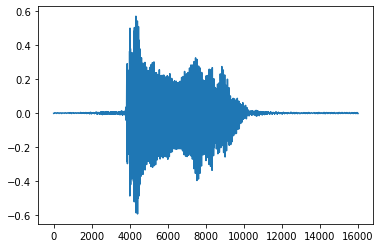

In [ ]:
ex = train_set[21523][0]
ex = fa.AudioTensor(ex)
plt.plot(ex[0])

In [ ]:
Audio(ex[0], rate = ex.shape[-1])

Aplicando la transformación mencionada obtendremos lo siguiente:

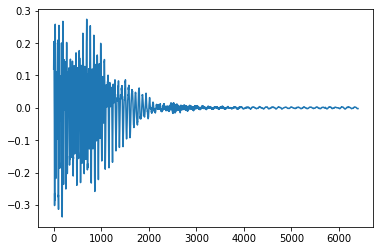

In [ ]:
ex = train_set[21523][0]
ex = fa.AudioTensor(ex)
res = fastaudio.augment.signal.ResizeSignal(duration = 400)
ex.sr = ex.shape[-1]
exr = res(ex)
plt.plot(exr[0])

In [ ]:
Audio(exr[0], rate = ex.sr)

Las demás transformaciones no se pueden observar directamente sobre un solo ejemplo de audio debido a que se aplican sobre batches. Pero entre ellas están

* *SignalShifter*: mueve aleatoriamente el audio a la izquierda o a la derecha.
* *AddNoise*: añade ruido de fondo de cierto tipo sobre la señal original de audio.
* *ChangeVolumne*: aumenta o disminuye el volumen de la señal de audio.
* *SignalCutOut*: selecciona un intervalo de la señal y la silencia.
* *SignalLoss*: selecciona un intervalo de la señal y la corta.

Para probar algunas de ellas, volvamos a cargar nuestros datos aplicando estas transformaciones.

In [ ]:
noise = fastaudio.augment.signal.AddNoise()
vol = fastaudio.augment.signal.ChangeVolume()
sShift = fastaudio.augment.signal.SignalShifter()
#sCut = fastaudio.augment.signal.SignalCutout()
#sLoss = fastaudio.augment.signal.SignalLoss()

btfms = [noise, vol, sShift]
data = load_data("./", b_tfms = btfms)

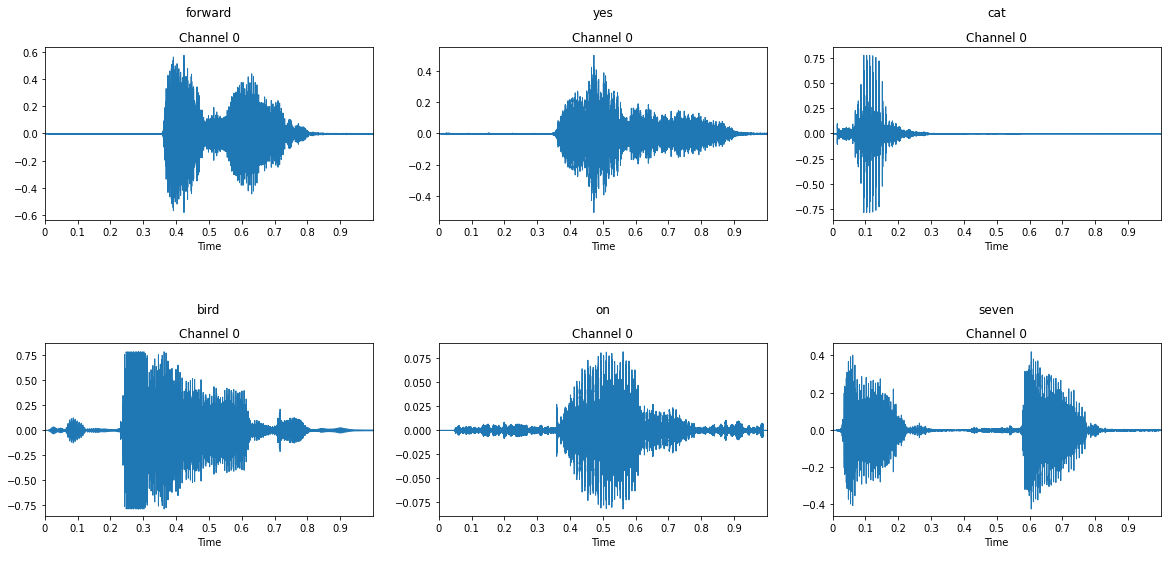

In [ ]:
data.show_batch(figsize=(20,10),nrows = 2, ncols = 3)

Para probar nuestro último modelo, creemos uno idéntico al primero que hicimos con este método. La única diferencia es que ahora está trabajando con ligeras transformaciones en las señales de audio al momento de cargar los datos.

In [ ]:
model = createWavModel()
model

Sequential(
  (0): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Conv1d(1, 32, kernel_size=(160,), stride=(16,))
  (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (4): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (7): ResBlock(
    (residual): Sequential(
      (0): Conv1d(64, 32, kernel_size=(1,), stride=(1,))
      (1): ReLU()
      (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): ReLU()
      (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (7

In [ ]:
learnWavAug = fv.Learner(data, model, metrics = fv.accuracy)

SuggestedLRs(lr_min=0.00831763744354248, lr_steep=0.3019951581954956)

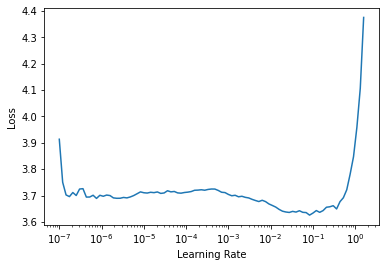

In [ ]:
learnWavAug.lr_find()

In [ ]:
learnWavAug.fit_one_cycle(5,5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.204280,1.535390,0.651061,04:31
1,0.789606,1.295246,0.766523,04:45
2,0.549449,1.427837,0.852412,04:35
3,0.417261,0.826367,0.893891,04:33
4,0.352529,0.774076,0.903387,04:37


De manera muy similar al primer modelo con este método, los resultados siguen siendo muy buenos. Volvimos a alcanzar el $90\%$ en tan solo cinco épocas.

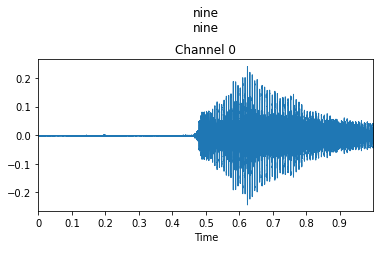

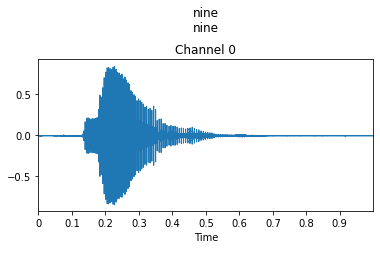

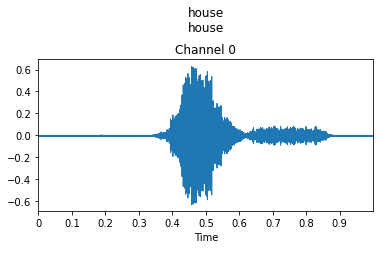

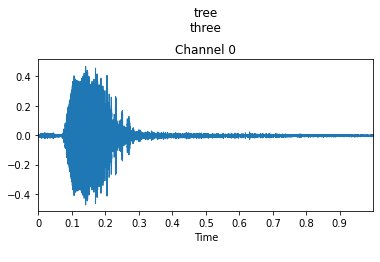

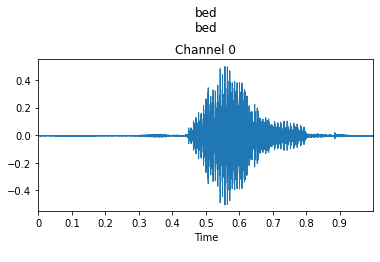

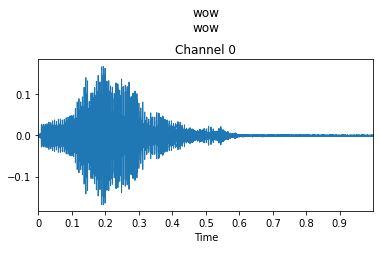

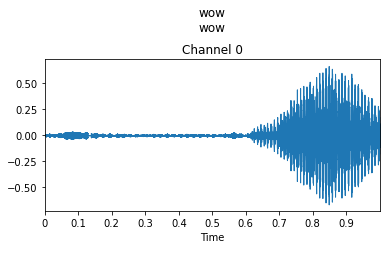

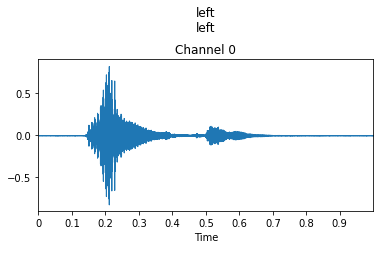

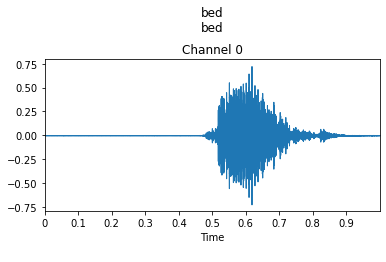

In [ ]:
learnWavAug.show_results()

In [ ]:
learnWavAug.save("learnWavAug")

Path('models/learnWavAug.pth')

In [ ]:
learnWavAug.load("learnWavAug")

# Conclusiones

En resumen este proyecto de clasificación muestra de manera muy general cómo hacer este proceso con archivos de audio.  Se ve cómo se representan las señales de sonido por medio de tensores y dos distintos métodos con redes neuronales convolucionales para llevar a cabo la clasificación.

El primero de ellos consistió en cambiar el formato de los archivos de audio, de un tensor de señal de audio de 1 x sr a una imagen de un canal. Esta imagen era un espectrograma, la cual es una forma visual de representar el audio. El proceso de clasificación fue idéntico al de clasificación de imágenes con redes neuronales convolucionales, pero considerando un solo canal de entrada.

El segundo trataba de insertar a la red neuronal el tensor de frecuencia de sonido directamente sin la necesidad de tener que hacer una transformación a un espectrograma. Para clasificar con base en esto, también se construyeron redes neuronales convolucionales y solo se tuvieron que hacer pequeños ajustes a la dimensión de las capas como BatchNorm y Convolution y al kernel_size de las primeras capas.

Si tuviéramos que comparar estos métodos de clasificación de audio con otros de clasificiación de imágenes, podríamos decir que ambos son extremadamente parecidos. Inclusive uno de ellos, no es nada más que una red neuronal convolucional para clasificar imágenes (espectrogramas).

Como observaciones adicionales, al momento de comparar el desempeño de los dos métodos, lo que parece interesante es que usar espectrogramas resultaba en mejores *accuracy* finales tras cinco épocas. La diferencia no era muy grande, pero sí se veía una ligera ventaja sobre los modelos que recibían el tensor de la señal de sonido de manera directa.


# Bibliografía

Coultas Blum, Harry A, Scart, Lucas G. y Braco, Robert. 2020. *Fastaudio*. *Github*. https://github.com/fastaudio/fastaudio. 

Pytorch. 2021. *Speech Command Classification with Torchaudio*. https://pytorch.org/tutorials/intermediate/speech_command_classification_with_torchaudio_tutorial.html 

Wei Dai, Chia Dai, Shuhui Qu, et al. 2016. *Very deep convolutional neural networks for raw waveforms*. https://arxiv.org/pdf/1610.00087.pdf


